In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from wholecell.utils import constants
from wholecell.utils import units
from models.ecoli.analysis.AnalysisPaths import AnalysisPaths

The rate of change of protein concentration is described as follows:

dp/dt = (er/protein_length) * mRNA_counts * transl_eff * fRibActive * ribosome_counts

        - (protein_decay_rate + (ln(2)/doubling_time))* protein_counts

er: ribosomal elongation rate aa/seconds

protein_length: monomer amino acid length

mRNA_counts: mRNA counts per cell

transl_eff: translation efficiency specific to each monomer (Javi normalized these)

fRibActive: fraction of active ribosomes

ribosome_counts: ribosome counts per cell

protein_decay_rate: protein degradation rate

doubling time: cell doubling time in seconds

protein_counts: protein counts per cell

# Generate Figure 5a from Science 2020 paper

In [88]:
# From Javi's calculations
# Constants
doubling_time = 45 #45 minutes
growthRate = np.log(2.) / (doubling_time / 60.) # doublings / hour
growthRatePerSec = growthRate / 3600. # doublings / sec
er = 16. # amino acids / sec, Bremer & Dennis 1996
fRibActive = 0.80 # Bremer & Dennis 1996
nAvogadro = 6.e23 # molecules/mole
mrnaMassFraction = 0.041 # Neidhardt, Physiology of the Bacterial Cell, 1931, p4
nucleotideMass = 324. # representative nucleotide, g/mole
aminoAcidMass = 118.9 # representative amino acid, g/mole
shortProteinHalfLife = 2. / 60. # hours
proteinHalfLife = 10. # hours

# Estimate macromolecular composition
# (functions were fit to values reported by Bremer & Dennis, 1996, Table 2)
cellMass = 6.e8 * growthRate**(-1.243) # cells/OD460
rnaMass = 4.e16 * np.exp(growthRate * 0.3101) # nt/OD460
proteinMass = 6.e17 * growthRate**(-0.19) # aa/OD460
ribosome_counts = 14576. * (growthRate**1.6473) # ribosome/cell

In [89]:
#source https://github.com/CovertLab/wcEcoli/blob/release-paper/paper/steadyStateAnalysis/main.py
# Path to files
dirname = '/Users/noravivancogonzalez/Downloads/javi_data/paper/steadyStateAnalysis'
PATH_TO_RNASEQ_DATA = os.path.join(dirname, "data/RNAseq/seal_rpkm_without_withAAs-bis.tsv") #which is not exactly the same as rnaseq_seal_rpkm_mean.tsv in the new model, I had used rnaseq_rsem_tpm_mean.tsv
PATH_TO_RNASEQ_MAP = os.path.join(dirname, "data/RNAseq/mapRNAseq2EcoMAC.tsv")
PATH_TO_PROTEOME = os.path.join(dirname, "data/Proteome/Proteome_Schmidt.tsv") #a bit diff because current table includes multiple media conditions
PATH_TO_TRANSLATION_EFFICIENCY = os.path.join(dirname, "data/TranslationEfficiency.tsv") #same but org a bit differently by ecocyc accession
PATH_TO_GENE = os.path.join(dirname, "data/EcoMAC/geneName.tsv") #this file no longer exists in current repo, so I downloaded it from release-paper branch
PATH_TO_MRNA = os.path.join(dirname, "data/EcoMAC/length_mRNA.tsv") #this file no longer exists in current repo, so I downloaded it from release-paper branch
PATH_TO_PROTEIN_DECAY = os.path.join(dirname, "data/proteinFastDecay.tsv") # doesn't exist in current repo
PATH_TO_OUTPUT_TSV = os.path.join(dirname, "steadyStateOutput.tsv")
PATH_TO_OUTPUT_PDF = os.path.join(dirname, "steadyStateOutput.pdf")

In [90]:
def computeMrna(cellMass, rnaMass, mrnaLength):
	# Load data
	rnaSeq2EcoMAC = np.array(openfile(PATH_TO_RNASEQ_MAP)[:, 0], dtype = int)
	rnaSeqData = np.array(openfile(PATH_TO_RNASEQ_DATA)[:, 1:], dtype = float)

	# Take log2 average of RNA seq data
	mask = rnaSeqData >= 1
	rnaSeqDataLog2 = np.zeros(rnaSeqData.shape)
	rnaSeqDataLog2[mask] = np.log2(rnaSeqData[mask])
	rnaSeqEcoMACFormat = rnaSeqDataLog2[rnaSeq2EcoMAC - 1, :]
	rnaLog2Averaged = 2. ** np.mean(rnaSeqEcoMACFormat, axis = 1)

	# Compute relative expression of each mRNA
	relativeExp = rnaLog2Averaged / np.sum(rnaLog2Averaged)

	# Compute counts of mRNA
	totalRnaMass = nucleotideMass / nAvogadro * rnaMass / cellMass # g/cell
	mrnaMass = mrnaLength / nAvogadro * nucleotideMass # g/mRNA
	mrnaTotalCounts = totalRnaMass * mrnaMassFraction / np.dot(relativeExp, mrnaMass) # counts/cell
	mrna = relativeExp * mrnaTotalCounts
	return mrna

def computeTranslationEff(): #had to edit this function so indexing would be correct
    data = openfile(PATH_TO_TRANSLATION_EFFICIENCY)
    vectorized_strip = np.vectorize(lambda x: x.strip('"\'') if isinstance(x, str) else x)
    geneNames = data[1:, 1]
    geneNames = vectorized_strip(geneNames)
    translationEff = np.array(data[1:, 2])
    translationEff[translationEff == '"NA"'] = np.nan
    translationEff = translationEff.astype(float)
    translationEff = mapData2EcoMAC(geneNames, translationEff)

	# Compute normalized translational efficiency
    mask = translationEff > 0
    translationEffAvg = 10.**np.mean(np.log(translationEff[mask]))
    translationEff[np.logical_not(mask)] = -translationEffAvg
    translationEffNormalized = translationEff / sum(abs(translationEff))
    return translationEffNormalized

def computeProteinDecay():
	fastDecay = openfile(PATH_TO_PROTEIN_DECAY)[:, 1]
	geneName2Id = makeGeneName2EcoMacId()
	fastDecayIndices = np.array([geneName2Id[x] for x in fastDecay if x in geneName2Id])

	# Compute protein decay rates (1/s)
	fastProteinDecay = np.log(2.) / (shortProteinHalfLife * 3600.)
	proteinDecay = np.log(2.) / (proteinHalfLife * 3600.) * np.ones(len(geneName2Id))
	proteinDecay[fastDecayIndices - 1] = fastProteinDecay
	return proteinDecay

def computeProtein(cellMass, proteinMass, proteinLength):
	# Load data
	rawdata = openfile(PATH_TO_PROTEOME)
	data = np.array(rawdata[:, 1], dtype = float)
	proteome = mapData2EcoMAC(rawdata[:, 0], data)

	# Compute total counts of protein
	mask = proteome <= 0
	proteomeMinCount1 = np.copy(proteome)
	proteomeMinCount1[mask] = 1.
	relativeExp = proteomeMinCount1 / np.sum(proteomeMinCount1)
	totalProteinMass = aminoAcidMass / nAvogadro * proteinMass / cellMass # g/cell
	proteinMass = proteinLength / nAvogadro * aminoAcidMass # g/protein
	proteinTotalCounts = totalProteinMass / np.dot(relativeExp, proteinMass) # counts/cell

	# Compute counts of each protein type
	proteomeMinCount0 = np.copy(proteome)
	proteomeMinCount0[mask] = 0
	protein = proteomeMinCount0 / np.sum(proteomeMinCount0) * proteinTotalCounts
	return protein

def makeGeneName2EcoMacId():
	data = openfile(PATH_TO_GENE)
	geneName2Id = dict(zip(data[:, 2], np.array(data[:, 0], dtype = int)))
	return geneName2Id

def mapData2EcoMAC(geneNames, data):
	geneName2Id = makeGeneName2EcoMacId()
	dataMappedToEcoMAC = -1 * np.ones(len(geneName2Id))
	for geneName, value in zip(geneNames, data):
		if geneName in geneName2Id:
			dataMappedToEcoMAC[geneName2Id[geneName] - 1] = value
	return dataMappedToEcoMAC

def openfile(filename):
	with open(filename, "r") as f:
		rawdata = f.readlines()
	data = []
	for line in rawdata:
		data.append(line.split())
	return np.array(data)

In [91]:
# Get lengths of mRNA transcripts (nucleotides) and proteins (amino acids)
mrnaLength = np.array(openfile(PATH_TO_MRNA)[:, 1], dtype = float)
proteinLength = mrnaLength / 3
# Compute mRNA
mrna = computeMrna(cellMass, rnaMass, mrnaLength)
translationEff = computeTranslationEff()
# Assign protein decay according to N-end rule
proteinDecay = computeProteinDecay()
# Compute protein
protein = computeProtein(cellMass, proteinMass, proteinLength)
# Identify genes for which all data are available
candidates = np.logical_and(np.logical_and(mrna > 0, protein > 0), translationEff > 0)
candidate_ecomac_ids = np.where(candidates)[0] +1
proteinLength = proteinLength[candidates]
mrna = mrna[candidates]
translationEff = translationEff[candidates]
protein = protein[candidates]
proteinDecay = proteinDecay[candidates]
gene_name_data = openfile(PATH_TO_GENE)
ecomac_id_to_gene_dict = dict(zip(np.array(gene_name_data[:, 0], dtype = int), gene_name_data[:, 2]))
gene_name_to_index_fig5a = {ecomac_id_to_gene_dict[ecomac_id]: i for i, ecomac_id in enumerate(candidate_ecomac_ids)}

genes_interest_dict = {'gshA': 'b', 
               'pnp': 'b',
               'carA': 'b',
               'cdsA': 'b',
               'dcuR': 'r',
               'bioD': 'r',
               'rph': 'r'}

# Compute production term
protein_production_fig5a = np.log10(er / proteinLength * mrna * translationEff * fRibActive * ribosome_counts)

# Compute loss term
protein_loss_fig5a = np.log10(protein * (proteinDecay + growthRatePerSec))


In [93]:
def plot_steady_state(protein_production, protein_loss, genes_interest_dict, gene_name_to_index):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.scatter(protein_production,protein_loss, c = "k", alpha = 0.1, s=8)
    ax_min = np.floor(min(ax.get_xlim()[0], ax.get_ylim()[0]))
    ax_max = np.ceil(max(ax.get_xlim()[1], ax.get_ylim()[1]))
    ax.plot([ax_min, ax_max], [ax_min, ax_max], "k", linewidth=1)
    ax.plot([ax_min, ax_max - 1], [ax_min + 1, ax_max], "k")
    ax.plot([ax_min + 1, ax_max], [ax_min, ax_max - 1], "k")
        
    for gene, color in genes_interest_dict.items():
        index = gene_name_to_index[gene]
        ax.scatter(protein_production[index], protein_loss[index], c=color, s=16)
        ax.text(protein_production[index] + 0.05, protein_loss[index] - 0.05, gene)
    ax.set_xlim([ax_min, ax_max])
    ax.set_ylim([ax_min, ax_max])
    ax.set_xlabel("Log10 production rate (protein/s)")
    ax.set_ylabel("Log10 loss rate (protein/s)")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    plt.tight_layout()

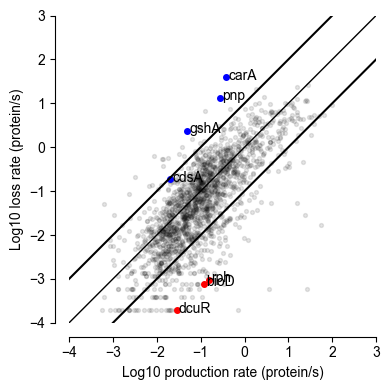

In [94]:
plot_steady_state(protein_production_fig5a, protein_loss_fig5a, genes_interest_dict, gene_name_to_index_fig5a)

# Generate equivalent protein steady state figure with values found in current model parca

In [65]:
raw_data_file_CLNE = '/Users/noravivancogonzalez/code/wcEcoli/out/pdr_CLNE_protease_assignment/kb/rawData.cPickle'
with open(raw_data_file_CLNE, 'rb') as f:
		raw_data = pickle.load(f)
simDataFile2 = '/Users/noravivancogonzalez/code/wcEcoli/out/pdr_CLNE_protease_assignment/kb/simData.cPickle'
with open(simDataFile2, 'rb') as f:
		sim_data = pickle.load(f)
validationDataFile = '/Users/noravivancogonzalez/code/wcEcoli/out/pdr_CLClim3aNE_protease_assignment/kb/validationData.cPickle'
with open(validationDataFile, 'rb') as f:
    validation_data = pickle.load(f)

# Compartment is listed differently in the protein to gene symbol validation data due to cell compartment being different, going to exclude cell compartment moving forward

In [199]:
cistron_ids = sim_data.process.translation.monomer_data['cistron_id']
er_parca = sim_data.process.translation.ribosomeElongationRateDict['minimal'].asNumber()
protein_lengths_parca = sim_data.process.translation.monomer_data['length'].asNumber()
transl_eff_parca = sim_data.process.translation.translation_efficiencies_by_monomer
transl_eff_norm_parca = transl_eff_parca/ sum(abs(transl_eff_parca))
RNA_SEQ_ANALYSIS = 'seal_rpkm' # seal rpkm is what Javi used but this file looks different than his
mRNA_length_dict = dict(zip(sim_data.process.transcription.cistron_data['id'],
                            sim_data.process.transcription.cistron_data['length'].asNumber()))
mRNA_lengths_order = np.array([mRNA_length_dict[cistron] for cistron in cistron_ids])
cistron_id_to_gene_symbol = { g['rna_ids'][0]: g['symbol'] for g in raw_data.genes}
gene_id_gene_symbol = {g['id']:g['symbol'] for g in raw_data.genes}
fRibActive_parca = sim_data.process.translation.ribosomeFractionActiveDict['minimal']
protein_decay_rates_CLNE_dict = dict(zip(sim_data.process.translation.monomer_data['cistron_id'], #using cistron id to avoid monomer compartment errors
                            sim_data.process.translation.monomer_data['deg_rate'].asNumber()))
protein_decay_rates_CLNE = np.array([protein_decay_rates_CLNE_dict[protein_id] for protein_id in cistron_ids])

# convert all naming to gene symbol

In [205]:
gene_symbols_ordered = np.array([cistron_id_to_gene_symbol[cistron_id] for cistron_id in cistron_ids])
validation_protein_id_gene_symbol_dict = {}
for gene, protein in validation_data.protein.geneSymbolToMonomerId.items():
    validation_protein_id_gene_symbol_dict[protein] = gene
gene_symbol_protein_counts_dict_schmidt = {
				validation_protein_id_gene_symbol_dict[item[0]]: item[1] for item in validation_data.protein.schmidt2015Data
				}
protein_counts_val = np.array([
    gene_symbol_protein_counts_dict_schmidt.get(gene, np.nan) for gene in gene_symbols_ordered
    ])

In [232]:
# protein_counts_val is in protein copies/cell and Javi did the following to the data
# 1) replaced protein copies <= 0 with 1 to avoid dividing by 0 when calculating relative expression
# 2) divides protein counts by total proteins to determine relative expression
# 3) goes back to the raw protein counts but replaces values <= 0 to 0
# 4) applies total protein mass into account to determine protein counts per cell

# Compute total counts of protein
zero_counts_mask = (protein_counts_val <= 0) | np.isnan(protein_counts_val)
proteomeMinCount1 = np.copy(protein_counts_val)
proteomeMinCount1[zero_counts_mask] = 1.

relativeExp = proteomeMinCount1 / np.sum(proteomeMinCount1)

totalProteinMass = aminoAcidMass / nAvogadro * proteinMass / cellMass # g/cell
proteinMass = protein_lengths_parca / nAvogadro * aminoAcidMass # g/protein
proteinTotalCounts = totalProteinMass / np.dot(relativeExp, proteinMass) # counts/cell

# Compute counts of each protein type
proteomeMinCount0 = np.copy(protein_counts_val)
proteomeMinCount0[zero_counts_mask] = 0
adj_protein_counts = proteomeMinCount0 / np.sum(proteomeMinCount0) * proteinTotalCounts

In [224]:
gene_symbol_mRNA_counts_dict_parca = {}
rna_seq_data_mean = getattr(raw_data.rna_seq_data, f'rnaseq_{RNA_SEQ_ANALYSIS}_mean')

for x in rna_seq_data_mean:
    gene_id = x['Gene']
    if gene_id in gene_id_gene_symbol:
        gene_symbol = gene_id_gene_symbol[gene_id]
        gene_symbol_mRNA_counts_dict_parca[gene_symbol] = x[sim_data.basal_expression_condition]
mRNA_counts_gene_symbol_order = np.array([
    gene_symbol_mRNA_counts_dict_parca.get(gene_id, np.nan) for gene_id in gene_symbols_ordered
    ])

In [284]:
# make adjustements to raw mrna counts like Javi
# Take log2 average of non-zero RNA seq data
zero_counts_mask = (mRNA_counts_gene_symbol_order <= 0) | np.isnan(mRNA_counts_gene_symbol_order)
log2_mRNA_counts = np.copy(mRNA_counts_gene_symbol_order)
log2_mRNA_counts[zero_counts_mask] = 0
log2_mRNA_counts[~zero_counts_mask] = np.log2(mRNA_counts_gene_symbol_order[~zero_counts_mask])
rnaLog2Averaged = 2. ** log2_mRNA_counts
# Compute relative expression of each mRNA
rnaRelativeExp = rnaLog2Averaged / np.sum(rnaLog2Averaged)
# Compute counts of mRNA
totalRnaMass = nucleotideMass / nAvogadro * rnaMass / cellMass # g/cell
mrnaMass = mRNA_lengths_order / nAvogadro * nucleotideMass # g/mRNA
mrnaTotalCounts = totalRnaMass * mrnaMassFraction / np.dot(rnaRelativeExp, mrnaMass) # counts/cell
adj_mrna_counts = rnaRelativeExp * mrnaTotalCounts

In [286]:
# Only select proteins with available mrna and protein counts and those greater than 0
mask_of_unavailable_values = np.isnan(adj_mrna_counts)|np.isnan(adj_protein_counts)|(adj_mrna_counts == 0)|(adj_protein_counts==0)
gene_symbols_available = gene_symbols_ordered[~mask_of_unavailable_values]
protein_counts_available = adj_protein_counts[~mask_of_unavailable_values]
mRNA_counts_available = adj_mrna_counts[~mask_of_unavailable_values]
protein_lengths_available = protein_lengths_parca[~mask_of_unavailable_values]
transl_eff_norm_available = transl_eff_norm_parca[~mask_of_unavailable_values]
protein_decay_rates_CLNE_available = protein_decay_rates_CLNE[~mask_of_unavailable_values]

gene_to_index = {
			gene: i for (i, gene)
			in enumerate(gene_symbols_available)
			}

protein_production_parca = np.log10((er_parca/protein_lengths_available) * mRNA_counts_available* 
                                    transl_eff_norm_available * fRibActive_parca * ribosome_counts)
protein_loss_parca = np.log10((protein_decay_rates_CLNE_available+ (np.log(2)/(doubling_time*60)))* protein_counts_available)
genes_interest_dict = {'gshA': 'b', 
               'pnp': 'b',
               'carA': 'b',
               'cdsA': 'b',
               'dcuR': 'r',
               'bioD': 'r',
               'rph': 'r'}

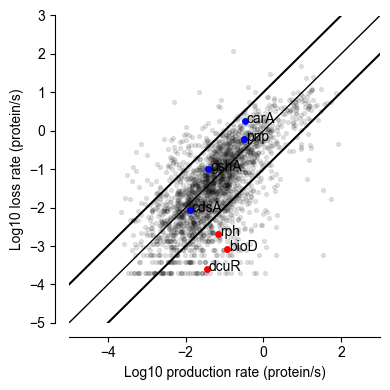

In [288]:
plot_steady_state(protein_production_parca, protein_loss_parca, genes_interest_dict, gene_to_index)